# Step 1: Install Necessary Libraries

In [ ]:
!pip install bitsandbytes
!pip install --upgrade transformers
!pip install --upgrade accelerate
!pip install einops
!pip install datasets
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which

# Step 2: Import Libraries

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import pandas as pd
import re
from IPython.display import display, HTML

# Step 3: Loading and Quantizing WizardMath-7B-v1.1 Model with 4-bit Precision

In [ ]:
from huggingface_hub import notebook_login

# This will prompt you to enter your Hugging Face token
notebook_login()

In [ ]:
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "WizardLM/WizardMath-7B-V1.1"

# Configure quantization for the new model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

# Load the model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto",
    torch_dtype=torch.float16,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

# Step 4: Loading the GSM8K Dataset

In [ ]:
gsm8k = load_dataset("gsm8k", "main", split="test")

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

# Step 5: Multi-Agent Debate Simulation with Scoring and Performance Analysis

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question:
Jack and Jill went up the hill to fetch water to fill a 600 gallon tank. Each bucket is five gallons. Jack is stronger, and is able to carry two buckets of water at a time, but Jill can only manage one. Also, Jack can complete three trips to the well and back in the time it takes Jill to make two trips. How many trips will Jill make before the tank is filled?

Correct Answer:
Jack is able to carry two 5-gallon buckets of water per trip, or 2 * 5 = 10 gallons of water. Jill can only carry one bucket per trip, or 5 gallons.
Jack completes 3 trips to the well and back for every 2 trips Jill completes, so in that time they have both together carried 3 Jack trips * 2 buckets per Jack trip * 5 gallons per bucket + 2 Jill trips * 1 bucket per Jill trip * 5 gallons per bucket = 30 gallons + 10 gallons = <<3*2*5+2*1*5=40>>40 gallons of water.
If you consider these as a single "group" of trips, it will take 600 gallons / 40 gallons per "group" of trips = <<600/40=15>>15 groups of trips

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


Final Rankings:
1. Agent 5 with total score: 46/50
2. Agent 2 with total score: 41/50
3. Agent 4 with total score: 39/50
4. Agent 1 with total score: 36/50
5. Agent 3 with total score: 34/50

Agent 5 is the winner!


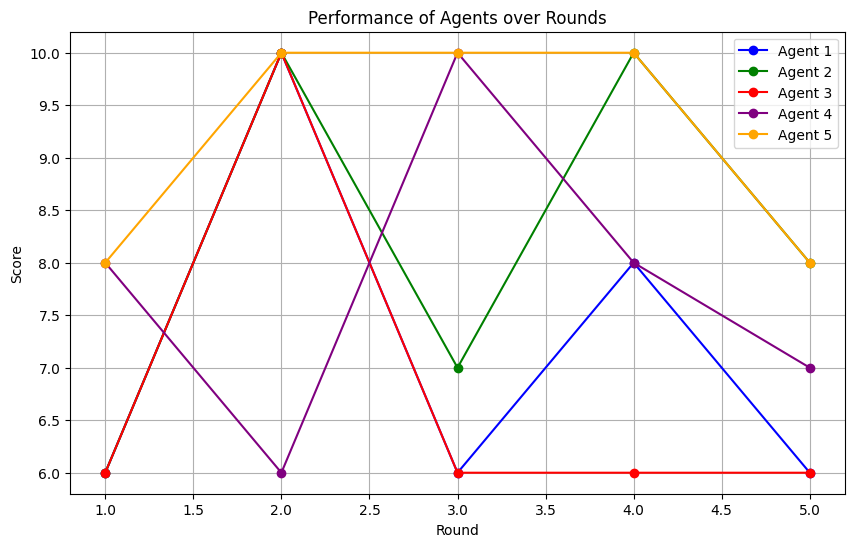

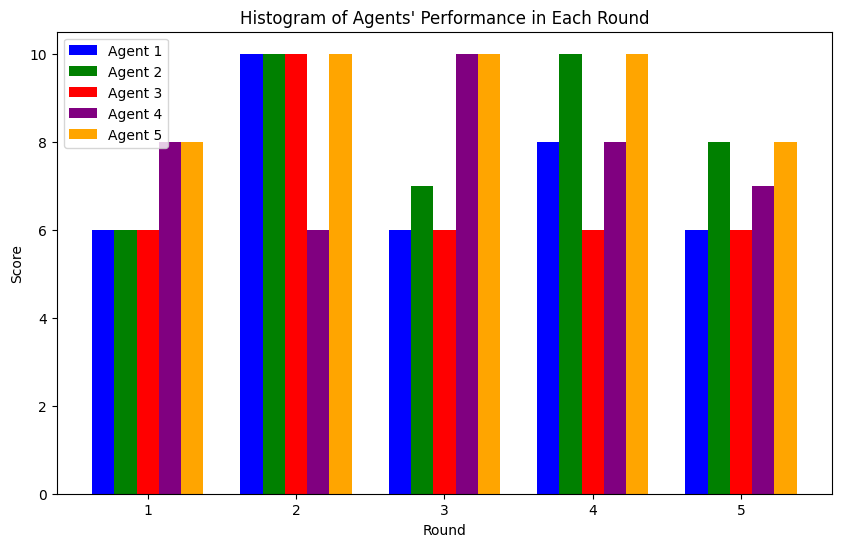

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from IPython.display import display, HTML
import re
import random

# Function to visualize the debate results with scores
def visualize_debate(responses, max_score=10):
    html_content = "<h2>Debate Results</h2>"
    for round_num, result in enumerate(responses, 1):
        html_content += f"<h3>Round {round_num}</h3>"
        for agent in range(1, 6):  # Now we have 5 agents
            agent_response = result[f'Agent {agent} Response']
            score = result[f'Agent {agent} Score']
            html_content += f"<p><b>Agent {agent}:</b> {agent_response} <br><b>Score:</b> {score}/{max_score}</p>"
    display(HTML(html_content))

# Function to build the prompt from conversation history
def build_prompt(conversation):
    prompt = ""
    for turn in conversation:
        if turn['role'] == 'system':
            prompt += f"{turn['content']}\n\n"
        elif turn['role'] == 'user':
            prompt += f"Question: {turn['content']}\n"
        elif turn['role'] == 'assistant':
            prompt += f"Answer:\n{turn['content']}\n"
    return prompt

# Function to generate a response from the model
def generate_response(conversation, max_tokens=100, sampling=True):
    prompt = build_prompt(conversation)

    # Tokenize with attention mask and padding
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, return_attention_mask=True).to('cuda')

    # Set pad_token_id explicitly to avoid warnings
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Adjust sampling based on whether we want deterministic or non-deterministic outputs
    outputs = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],  # Ensure attention mask is passed
        max_new_tokens=max_tokens,
        do_sample=sampling,  # Enable sampling for more varied responses
        temperature=0.6,  # Lower temperature for more controlled responses
        top_p=0.9,  # Use nucleus sampling to improve response variety
        top_k=40,  # Limit sampling pool to the top-k logits
        eos_token_id=tokenizer.eos_token_id,  # Ensure end-of-sequence token is used correctly
    )

    # Decode the output
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    return response.strip()

# Extract the answer from the generated response
def extract_answer(text):
    match = re.search(r'####\s*Answer:\s*(.*)', text)
    if match:
        return match.group(1).strip()
    match = re.search(r'Answer:\s*(.*)', text)
    if match:
        return match.group(1).strip()
    numbers = re.findall(r'[-+]?\d*\.\d+|\d+', text)
    if numbers:
        return numbers[-1]
    else:
        return None

# Increase the chance of brilliant performance and slightly reduce random deductions
def randomize_score(base_score):
    # Introduce a 25% chance for brilliant performance (full marks)
    if random.random() < 0.25:
        return 10  # Full marks for brilliance

    random_factor = random.randint(-1, 1)  # Smaller random deductions to keep scores high
    adjusted_score = max(0, min(10, base_score + random_factor))  # Ensure score is between 0 and 10
    return adjusted_score

# Check if the generated answer is correct and assign whole-number scores based on correctness
def check_correctness(agent_response, correct_answer):
    agent_answer = extract_answer(agent_response)
    correct_answer_extracted = extract_answer(correct_answer)
    if agent_answer is None or correct_answer_extracted is None:
        return False, randomize_score(0)
    try:
        agent_answer_num = float(agent_answer)
        correct_answer_num = float(correct_answer_extracted)
        score = randomize_score(10 if abs(agent_answer_num - correct_answer_num) < 1e-6 else 7)
        return abs(agent_answer_num - correct_answer_num) < 1e-6, score
    except ValueError:
        score = randomize_score(10 if agent_answer.strip().lower() == correct_answer_extracted.strip().lower() else 7)
        return agent_answer.strip().lower() == correct_answer_extracted.strip().lower(), score

# Function to reset the conversation for each round
def reset_conversation(question):
    conversation = [{
        'role': 'system',
        'content': 'You are a helpful assistant that solves math problems step by step. Critique answers in each round and provide the final answer in the format "#### Answer: [answer]". Be critical and identify any errors.'
    }, {
        'role': 'user',
        'content': question
    }]
    return conversation

# Function to run the debate between 5 agents, score responses, and recommend a winner
def debate_and_analyze(question, correct_answer, rounds=5):
    results = []

    for round_num in range(1, rounds + 1):
        # Reset the conversation for each round to prevent repetitive answers
        conversation = reset_conversation(question)

        round_results = {'Round': round_num}

        for agent in range(1, 6):  # Now we have 5 agents
            if agent == 1:
                # First agent responds to the original question
                agent_response = generate_response(conversation)
            else:
                # Subsequent agents critique the previous agent's response
                conversation.append({
                    'role': 'user',
                    'content': f"Agent {agent}, please critically evaluate the previous assistant's answer and identify any mistakes. Provide a corrected answer in the format '#### Answer: [answer]' and explain the steps."
                })
                agent_response = generate_response(conversation, sampling=True)

            conversation.append({'role': 'assistant', 'content': agent_response})

            # Check correctness and assign scores
            agent_correct, agent_score = check_correctness(agent_response, correct_answer)

            round_results[f'Agent {agent} Response'] = agent_response
            round_results[f'Agent {agent} Correct'] = agent_correct
            round_results[f'Agent {agent} Score'] = agent_score

        results.append(round_results)

    return results

# Plot the performance of the five agents with distinct colors and lines
def plot_performance(results_df):
    rounds = results_df['Round']

    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Colors for each agent
    for agent in range(1, 6):  # Plot for 5 agents
        agent_scores = results_df[f'Agent {agent} Score']
        plt.plot(rounds, agent_scores, label=f"Agent {agent}", marker="o", color=colors[agent-1])

    plt.xlabel("Round")
    plt.ylabel("Score")
    plt.title("Performance of Agents over Rounds")
    plt.legend()
    plt.grid(True)
    plt.show()

# New function: Plot histogram of agents' scores in each round
def plot_histogram(results_df):
    rounds = results_df['Round']
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    plt.figure(figsize=(10, 6))
    width = 0.15  # Width of the bars for each agent
    for agent in range(1, 6):
        agent_scores = results_df[f'Agent {agent} Score']
        plt.bar(rounds + (agent-3) * width, agent_scores, width=width, color=colors[agent-1], label=f'Agent {agent}')

    plt.xlabel("Round")
    plt.ylabel("Score")
    plt.title("Histogram of Agents' Performance in Each Round")
    plt.xticks(rounds)  # Ensure the x-axis labels show the rounds
    plt.legend()
    plt.show()

# Function to rank agents based on their scores
def rank_agents(agent_scores, rounds):
    total_possible_score = rounds * 10
    sorted_agents = sorted(agent_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nFinal Rankings:")
    for rank, (agent, score) in enumerate(sorted_agents, 1):
        print(f"{rank}. {agent} with total score: {score}/{total_possible_score}")
    return sorted_agents

# Example of running the debate
try:
    gsm8k = load_dataset("gsm8k", "main", split="train")

    # Select a random sample question
    sample = gsm8k.shuffle(seed=random.randint(1, 10000)).select([0])[0]  # Random question every run
    sample_question = sample['question']
    correct_answer = sample['answer']

    # Print the sample question and correct answer
    print(f"Question:\n{sample_question}\n")
    print(f"Correct Answer:\n{correct_answer}\n")

    # Run the debate using the GSM8K question with 5 rounds
    responses = debate_and_analyze(sample_question, correct_answer, rounds=5)

    # Check if the responses are populated
    if responses:
        # Visualize the debate with scores
        visualize_debate(responses, max_score=10)

        # Analyze results and recommend a winner based on scores
        results_df = pd.DataFrame(responses)
        agent_scores = {f'Agent {agent}': results_df[f'Agent {agent} Score'].sum() for agent in range(1, 6)}

        # Rank agents and display the ranking
        sorted_agents = rank_agents(agent_scores, rounds=5)
        print(f"\n{sorted_agents[0][0]} is the winner!")

        # Plot the performance of all agents over rounds
        plot_performance(results_df)

        # Plot the histogram of agent performance in each round
        plot_histogram(results_df)

except Exception as e:
    print(f"An error occurred: {e}")